In [2]:
import pandas as pd
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv('weather.csv', sep = '\t',parse_dates= True)

In [16]:
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'], format='%d.%m.%Y', dayfirst= True)

In [166]:
df.columns = ['ds','y']
df.loc[(df['y'] < 40000) | (df['y'] > 80000), 'y'] = None
m = Prophet(  mcmc_samples = 300       )
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Insaf.Ashrapov\AppData\Local\Continuum\miniconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Insaf.Ashrapov\AppData\Local\Continuum\miniconda3\lib\site-packages\pystan\misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [ ]:
future = m.make_future_dataframe(periods=12, freq = 'M')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

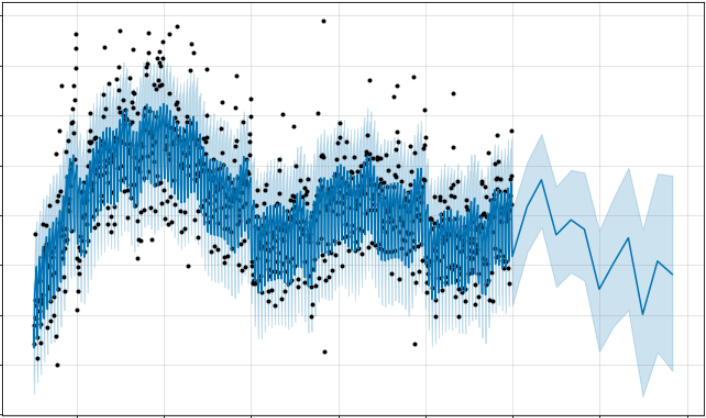

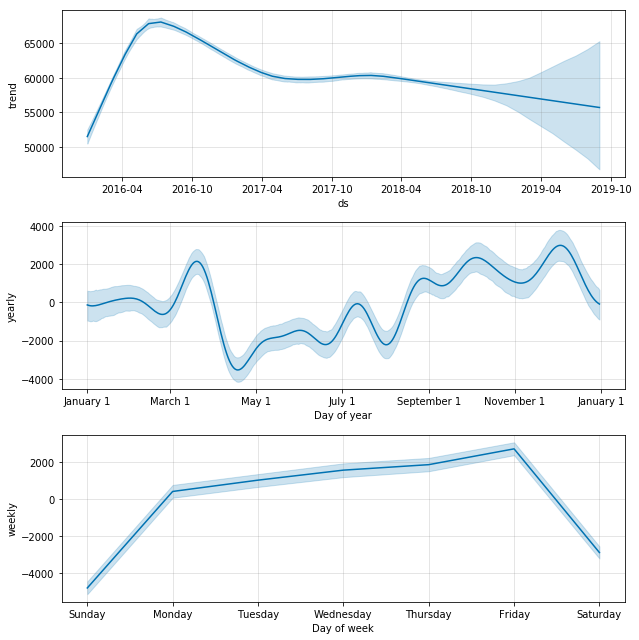

In [169]:
fig2 = m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='360 days', period='25 days', horizon = '61 days')
df_cv.head()

In [159]:
def mean_absolute_percentage_error(y_true, y_pred):  
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [160]:
df_m = df_cv.copy()
df_m['horizon'] = df_m['ds'] - df_m['cutoff']
df_m.sort_values('horizon', inplace=True)

In [161]:
#df_m = df_m[df_m.horizon > '30 days']

In [ ]:
total = df_m.groupby('cutoff', as_index=False).sum()
mapes = []
for bgn_date in total.cutoff:
    val = mean_absolute_percentage_error(total[total.cutoff == bgn_date].y, total[total.cutoff == bgn_date].yhat)
    mapes.append(val)

In [163]:
print('колво предиктов ', len(mapes))
num_more5 = 0
for val in mapes:
    if val > 0.05:
        num_more5 += 1
print('Кол-во предиктов больше 5%: ', num_more5)

колво предиктов  24
Кол-во предиктов больше 5%:  9


In [164]:
np.mean(mapes)

0.0526174800018338

In [65]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
254,7 days,1.471472e+07,3835.976497,3162.424837,0.053222,0.813953
68,7 days,1.420103e+07,3768.425406,3080.341268,0.051694,0.837209
192,7 days,1.399253e+07,3740.659582,3021.770266,0.050748,0.837209
130,7 days,1.378017e+07,3712.164720,2981.706536,0.049877,0.837209
316,7 days,1.302994e+07,3609.701498,2867.694888,0.048264,0.860465


In [60]:
import seaborn as sn
def plot_cross_validation_metricv2(df_cv, metric, rolling_window=0.1, ax=None):
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=(10, 6))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    # Get the metric at the level of individual predictions, and with the rolling window.
    df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=0)
    df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

    # Some work because matplotlib does not handle timedelta
    # Target ~10 ticks.
    tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
    # Find the largest time resolution that has <1 unit per bin.
    dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
    dt_names = [
        'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
        'nanoseconds'
    ]
    dt_conversions = [
        24 * 60 * 60 * 10 ** 9,
        60 * 60 * 10 ** 9,
        60 * 10 ** 9,
        10 ** 9,
        10 ** 6,
        10 ** 3,
        1.,
    ]
    for i, dt in enumerate(dts):
        if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
            break

    x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
    x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])

    ax.plot(x_plt, df_none[metric], '.', alpha=0.5, c='gray')
    ax.plot(x_plt_h, df_h[metric], '-', c='b')
    ax.grid(True)

    ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
    ax.set_ylabel(metric)
    return fig

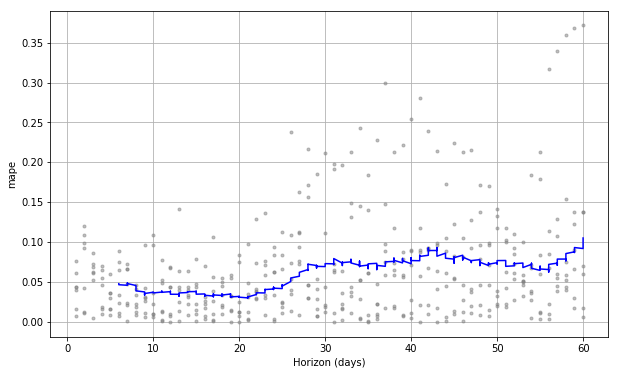

In [61]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metricv2(df_cv, metric='mape')